In [2]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
from scipy import special
from random import gauss
#import hdf5storage
import h5py
import timeit
from numba import jit
#from sympy.solvers.solveset import nonlinsolve
#from sympy.core.symbol import symbols
#from sympy import exp
from scipy import stats
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.analysis import *
from core.simulation import *

E:\Users\Marco1\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


####################################################################################################### 
#(RUN ONLY IF NEEDED) 
#Obtain 1-normalized laplacian eigenvalues & eigenvectors from Selen's data and save them to file

f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
Adjacency = sparse.csc_matrix( (f['combined']['A']['data'], f['combined']['A']['ir'], f['combined']['A']['jc']) ).toarray()
CC = np.asarray(f['CC']['restInds'], dtype=int)
#Laplacian = sparse.csc_matrix( (f['combined']['L']['data'], f['combined']['L']['ir'], f['combined']['L']['jc']) ).toarray()
#Degree = sparse.csc_matrix( (f['combined']['DegreeM']['data'], f['combined']['DegreeM']['ir'], f['combined']['DegreeM']['jc']) ).toarray()
f.close()
indices = np.array([elem[0] for elem in CC])-1
Adjacency = Adjacency[indices,:]
Adjacency = Adjacency[:,indices]
Deg=np.sum(Adjacency, axis=0)
sqrt_Deg=np.power(Deg,-0.5)
Degree_Matrix=sp.sparse.diags(Deg)
sqrt_Degree_Matrix=sp.sparse.diags(sqrt_Deg)
regLap = Degree_Matrix - sp.sparse.csc_matrix(Adjacency)
Laplacian = (sp.sparse.csc_matrix.dot(sqrt_Degree_Matrix,sp.sparse.csc_matrix.dot(regLap,sqrt_Degree_Matrix))).toarray()
Laplacian[Laplacian>1]=1

eigenvalues2, eigenvectors2 = np.linalg.eigh(Laplacian)
#eigenvectors2 matrix: each COLUMN eigenvectors2[:,i] is a normalized eigenvector

#do we want to set the first eigenvalues to the known value, which should be zero?
#eigenvalues2[0] = 0
#1-norm normalization
for col in range(eigenvectors2.shape[1]):
    eigenvectors2[:,col]/=np.sum(eigenvectors2[:,col])


#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals.npy', eigenvalues2)
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy', eigenvectors2)


In [3]:
#If known, read eigenvalues and eigenvectors from file
eigenvalues2 = np.load('../data/eigvals.npy')
#eigenvectors2 = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy')

In [5]:
#Set parameters and bounds for minimization algorithms
aEE, bnds_aEE = 30, (0.01,500)
aIE, bnds_aIE = 20, (0.01,500)
aEI, bnds_aEI = 150, (0.01,500)
aII, bnds_aII = 15, (0.01,500)
dE, bnds_dE = 5, (0.01,20)
dI, bnds_dI = 5, (0.01,20)
P, bnds_P = 1, (0,10)
Q, bnds_Q = 0, (0,10)
sEE, bnds_sEE = 30, (0,500)
sIE, bnds_sIE = 45, (0,500)
sEI, bnds_sEI = 169, (0,500)
sII, bnds_sII = 60, (0,500)
D, bnds_D = 1, (0.1,10)             #unchanged
tE, bnds_tE = 1, (0.01,10)          #unchanged
tI, bnds_tI = 1, (0.01,10)          #unchanged
snE, bnds_snE = 1, (1,10)        #unchanged
snI, bnds_snI = 1, (1,10)         #unchanged

initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,D,tE,tI,snE,snI]) 
bnds=[bnds_aEE,bnds_aIE,bnds_aEI,bnds_aII,bnds_dE,bnds_dI,bnds_P,bnds_Q,bnds_sEE,bnds_sIE,bnds_sEI,bnds_sII,bnds_D,bnds_tE,bnds_tI,bnds_snE,bnds_snI]

Graph_Kernel='Gaussian'
first_k=2
True_Spectrum = 15*(np.arange(first_k,5000)**(-0.3))
LSA=True
Visual=False
SaveFiles=False
FilePath=' '

Args = (eigenvalues2, Graph_Kernel, True_Spectrum, first_k, LSA, Visual, SaveFiles)

E*=0.03197, I*=0.1889: stable, with nonzero imaginary components
E*=0.2, I*=0.2044: strictly stable
Best suitable steady state: 0, with Ess=0.032 Iss=0.189, Distance: 12.664


<IPython.core.display.Javascript object>


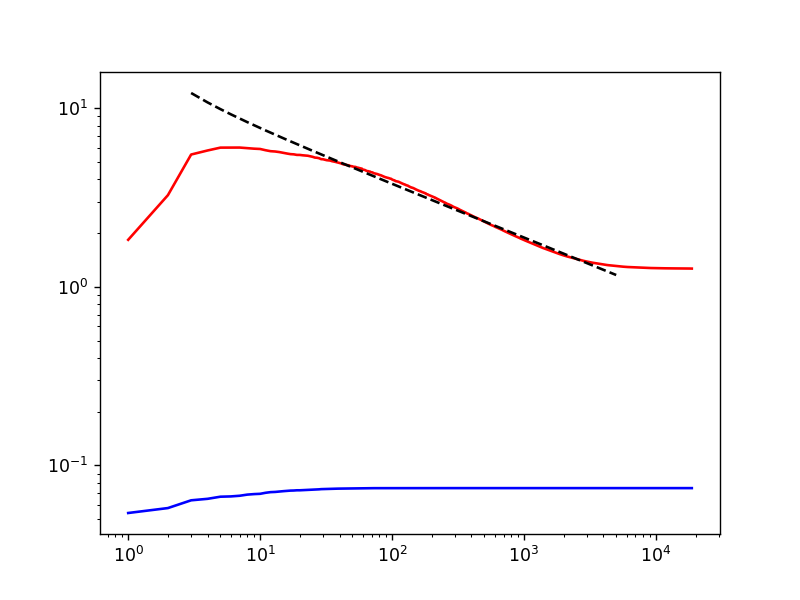

12.664290102119843

In [152]:
############################
#single analysis for easy visualization (note that if there are multiple stedy states the visualization will refer to the best one)
Full_Analysis(better_result['x'], eigenvalues2, Graph_Kernel, True_Spectrum, first_k, LSA, True, SaveFiles, FilePath)

In [ ]:
############################
#simple attempt at power spectrum fitting with a minimization algorithm. May get stuck in local minima.
#playing around with tolerance and max number of iterations is often necessary, depending on initial conditions. e.g.
#First run with fairly random initial guess: tol=1e-03, no maxiter (will take a while)
#Run starting from a previously obtained result: tol=1e-08, 'maxiter':2000

#initial_guess=better_result['x']
result = sp.optimize.minimize(Full_Analysis, initial_guess, args=Args,
                              method='Nelder-Mead',#'L-BFGS-B', 
                              bounds=bnds, 
                              tol=1e-08)
                             # options={'maxiter':2000})

In [ ]:
############################
#more complicated fitting attempt with basinhopping stochastic minimization
#to obtain good results in sensible amounts of time, playing with minimization parameters is required
#the relevant parameter are again tolerance and maxiter, similarly to above (which affect the local minimization loop)
#but also niter and stepsize. these specify how many local minimizations we wish to carry out, 
#and the size of the basin-hopping random step inbetween local minimizations

new_initial_guess=better_result['x']
#new_initial_guess=initial_guess

#sort of ugly, but need to defind bounds manually for basinhopping
class MyBounds(object):
    def __init__(self, xmax=[elem[1] for elem in bnds], xmin=[elem[0] for elem in bnds] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        t=tmax and tmin
        
        Steady_States, Success = H_Simple_Steady_State(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])
        print(t and Success)
        return t and Success
    #potential TODO: only accept parameter sets that return stable positive steady states (actually no: they might be locally near a suitable state. still worth to do local minimization)

mybounds = MyBounds()

#minimizer_kwargs={'args':Args, 'method':'TNC', 'bounds':bnds, 'tol':1e-03, 'options':{'maxiter':500}}


def custom_min(fun, x0, args, **kwargs):
    Bounds=bnds
    Bounds[0:8]=[(elem,elem) for elem in x0[0:8]]
     
    return sp.optimize.minimize(fun,x0,args=Args, method='Nelder-Mead',# bounds=Bounds,
                                tol=1e-08,
                                options={'maxiter':800})


better_result = sp.optimize.basinhopping(Full_Analysis, new_initial_guess, niter=100, stepsize=0.5,
                                  minimizer_kwargs=dict(method=custom_min),
                                  accept_test=MyBounds())

#initial_guess=better_result['x']

E*=0.1746, I*=0.2066: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.207, Distance: 15.908
E*=0.1885, I*=0.2066: strictly stable
Best suitable steady state: 0, with Ess=0.188 Iss=0.207, Distance: 39.764
E*=0.1746, I*=0.2066: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.207, Distance: 15.908
E*=0.1862, I*=0.1968: strictly stable
Best suitable steady state: 0, with Ess=0.186 Iss=0.197, Distance: 37.96
E*=0.1746, I*=0.2066: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.207, Distance: 17.181
E*=0.1746, I*=0.2066: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.207, Distance: 15.908
E*=0.1746, I*=0.2066: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.207, Distance: 15.908
E*=0.1746, I*=0.2066: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.207, Distance: 15.908
E*=0.1746, I*=0.2066: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.207, Distance: 

E*=0.1716, I*=0.2067: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.808
E*=0.1515, I*=0.2068: unstable
E*=0.1498, I*=0.2066: unstable
E*=0.1729, I*=0.2066: strictly stable
Best suitable steady state: 1, with Ess=0.173 Iss=0.207, Distance: 12.438
E*=0.1715, I*=0.2069: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.951
E*=0.1713, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.207, Distance: 11.932
E*=0.1728, I*=0.2067: strictly stable
Best suitable steady state: 0, with Ess=0.173 Iss=0.207, Distance: 12.175
E*=0.1709, I*=0.2069: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.207, Distance: 12.588
E*=0.1529, I*=0.2069: unstable
E*=0.1706, I*=0.2069: strictly stable
Best suitable steady state: 1, with Ess=0.171 Iss=0.207, Distance: 13.319
E*=0.1515, I*=0.2067: unstable
E*=0.1716, I*=0.2067: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.20

E*=0.151, I*=0.2068: unstable
E*=0.172, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.597
E*=0.1718, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.583
E*=0.151, I*=0.2068: unstable
E*=0.02503, I*=0.1713: stable, with nonzero imaginary components
E*=0.172, I*=0.2068: strictly stable
Best suitable steady state: 1, with Ess=0.172 Iss=0.207, Distance: 11.549
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.549
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.552
E*=0.172, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.557
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.56
E*=0.1512, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state

Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.525
E*=0.02503, I*=0.1713: stable, with nonzero imaginary components
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 1, with Ess=0.172 Iss=0.207, Distance: 11.525
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.523
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.523
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.522
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 1, with Ess=0.172 Iss=0.207, Distance: 11.522
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.522
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 1, with Ess=0.172 Iss=0.207, D

Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.52
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.52
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.52
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.52
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.52
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 1, with Ess=0.172 Iss=0.207, Distance: 11.52
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.52
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.52
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=

E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 1, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.02503, I*=0.1713: stable, with nonzero imaginary components
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 1, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: stric

E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 1, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.02503, I*=0.1713: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.171, Distance: 27.186
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.02503, I*=0.1713: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.171, Distance: 27.186
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1511, I*=0.2068: unstable
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 1, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, 

Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 1, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.

Best suitable steady state: 1, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.02503, I*=0.1713: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.171, Distance: 27.186
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable s

E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.207, Distance: 11.519
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 1, with

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, wit

Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.166, Distance: 57.082
E*=0.01957, I*=0.1659: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.205 Iss=0.203, Distance: 57.663
E*=0.2049, I*=0.2032: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.203, Distance: 58.015
E*=0.2065, I*=0.2032: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.203, Distance: 59.106
E*=0.1014, I*=0.2032: unstable
E*=0.2045, I*=0.2032: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.203, Distance: 59.032
E*=0.2045, I*=0.2032: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.203, Distance: 57.546
E*=0.2045, I*=0.2032: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.203, Distance: 57.663
E*=0.2045, I*=0.2032: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.203, Distance: 57.663
E*=0.204, I*=0.2026: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.203, Distance: 57.723
E*=0.2039, I*=0.2025: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.203, Distance: 57.73
E

Best suitable steady state: 0, with Ess=0.199 Iss=0.213, Distance: 53.178
E*=0.1994, I*=0.2126: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.213, Distance: 53.824
E*=0.1986, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.213, Distance: 53.273
E*=0.199, I*=0.2132: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.213, Distance: 53.27
E*=0.1989, I*=0.2133: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.213, Distance: 53.213
E*=0.1989, I*=0.2132: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.213, Distance: 53.15
E*=0.1224, I*=0.2132: unstable
E*=0.1989, I*=0.2132: strictly stable
Best suitable steady state: 1, with Ess=0.199 Iss=0.213, Distance: 53.168
E*=0.1989, I*=0.2131: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.213, Distance: 53.193
E*=0.1989, I*=0.2132: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.213, Distance: 53.196
E*

E*=0.1984, I*=0.2133: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.928
E*=0.1984, I*=0.2133: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.92
E*=0.1984, I*=0.2133: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.926
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.914
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.914
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.913
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.914
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.907
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with 

Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.905
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitab

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, 

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.

Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitab

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904

Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance:

E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1231, I*=0.2134: unstable
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.213, Distance: 52.904
E*=0.1984, I*=0.2134: strictly stable
Best suitable steady state: 0, with

E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stab

E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stab

E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stab

E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stab

E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.018 Iss=0.159, Distance: 42.152
E*=0.01794, I*=0.1594: stab

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.264
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.264
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.264
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.264
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.264
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.265
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.264
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.019 Iss=0.155, Distance: 39.261
E*=0.0191, I*=0.1552: stable, with

Best suitable steady state: 0, with Ess=0.206 Iss=0.213, Distance: 38.631
E*=0.2062, I*=0.2132: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.213, Distance: 38.631
E*=0.2062, I*=0.2132: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.213, Distance: 38.631
E*=0.2054, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.213, Distance: 38.619
E*=0.2056, I*=0.2134: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.213, Distance: 38.293
E*=0.2038, I*=0.2141: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.214, Distance: 37.137
E*=0.2035, I*=0.2142: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.214, Distance: 36.962
E*=0.2031, I*=0.2143: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.214, Distance: 37.046
E*=0.2054, I*=0.2135: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.214, Distance: 38.146
E*=0.1997, I*=0.2159: strictly

E*=0.1404, I*=0.2189: unstable
E*=0.1984, I*=0.2189: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.219, Distance: 32.475
E*=0.1404, I*=0.2189: unstable
E*=0.1984, I*=0.2189: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.219, Distance: 32.517
E*=0.1985, I*=0.2189: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.219, Distance: 32.544
E*=0.1984, I*=0.2189: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.219, Distance: 32.554
E*=0.1986, I*=0.2189: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.219, Distance: 32.662
E*=0.1987, I*=0.2188: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.219, Distance: 32.694
E*=0.1401, I*=0.2188: unstable
E*=0.1987, I*=0.2188: strictly stable
Best suitable steady state: 1, with Ess=0.199 Iss=0.219, Distance: 32.722
E*=0.1987, I*=0.2189: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.219, Distance: 32.791
E*=0.1987, 

E*=0.1973, I*=0.2193: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.219, Distance: 31.574
E*=0.1968, I*=0.2195: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.219, Distance: 31.158
E*=0.1967, I*=0.2195: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.219, Distance: 31.137
E*=0.1968, I*=0.2195: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.219, Distance: 31.152
E*=0.1427, I*=0.2195: unstable
E*=0.1971, I*=0.2194: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.219, Distance: 31.461
E*=0.1971, I*=0.2194: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.219, Distance: 31.455
E*=0.1971, I*=0.2194: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.219, Distance: 31.445
E*=0.1967, I*=0.2195: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.219, Distance: 31.125
E*=0.1428, I*=0.2195: unstable
E*=0.1422, I*=0.2194: unstable
E*=0.1967, 

Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.804
E*=0.1964, I*=0.2196: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.797
E*=0.1964, I*=0.2196: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.873
E*=0.1964, I*=0.2196: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.87
E*=0.1433, I*=0.2196: unstable
E*=0.1963, I*=0.2196: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.792
E*=0.1432, I*=0.2196: unstable
E*=0.1964, I*=0.2196: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.863
E*=0.1963, I*=0.2196: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.784
E*=0.1963, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.733
E*=0.1964, I*=0.2196: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0

Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.606
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.607
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.609
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.597
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.593
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.594
E*=0.02577, I*=0.1822: stable, with nonzero imaginary components
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.182, Distance: 26.161
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.576
E*=0.1961, I*=0.2197: strictly stable
Best suitable s

Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.577
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.576
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.574
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.574
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.574
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.574
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.574
E*=0.196

E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.576
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.576
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.576
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.576
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.576
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.576
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.576
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.576
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.1

Best suitable steady state: 0, with Ess=0.026 Iss=0.182, Distance: 26.161
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.14

Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.196

Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=

E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.1

Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.196

E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E

E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.1

E*=0.1436, I*=0.2197: unstable
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitabl

E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E

E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E

Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: stri

E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.1

E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E

E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1436, I*=0.2197: unstable
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 1, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.219

Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.22, Distance: 30.575
E*=0.1961, I*=0.2197: strictly stable
B

Best suitable steady state: 0, with Ess=0.214 Iss=0.197, Distance: 55.13
E*=0.2145, I*=0.1992: strictly stable
Best suitable steady state: 0, with Ess=0.215 Iss=0.199, Distance: 55.276
E*=0.2132, I*=0.1992: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.199, Distance: 54.163
E*=0.03128, I*=0.1815: stable, with nonzero imaginary components
E*=0.2134, I*=0.1988: strictly stable
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 16.763
E*=0.2137, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 54.677
E*=0.2124, I*=0.1988: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.199, Distance: 53.931
E*=0.2138, I*=0.1979: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.198, Distance: 54.864
E*=0.213, I*=0.2003: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.2, Distance: 54.271
E*=0.2136, I*=0.1992: strictly stable
Best suitable steady state: 0, with Ess=0.2

E*=0.03142, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.898
E*=0.03142, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.898
E*=0.03142, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.898
E*=0.03142, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.898
E*=0.03142, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.898
E*=0.03142, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.912
E*=0.03142, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.922
E*=0.03139, I*=0.1817: stab

E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.453
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.03143, I*=0.1817: stable, with nonzero imaginary components
E*=0.2138, I*=0.1992: strictly stable
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.839
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
B

Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Di

E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance:

E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitabl

Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.09345, I*=0.1991: unstable
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 1, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214

Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: s

Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess

E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.03144, I*=0.1817: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.031 Iss=0.182, Distance: 14.836
E*=0.2138, I*=0.1991: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.199, Distance: 53.452
E*=0.2138, I*=0.

E*=0.2111, I*=0.188: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 63.521
E*=0.2116, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.188, Distance: 64.909
E*=0.2117, I*=0.188: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.188, Distance: 63.488
E*=0.2117, I*=0.188: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.188, Distance: 63.488
E*=0.2117, I*=0.188: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.188, Distance: 63.488
E*=0.2117, I*=0.188: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.188, Distance: 62.027
E*=0.212, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.188, Distance: 63.403
E*=0.2112, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 63.2
E*=0.21, I*=0.188: strictly stable
Best suitable steady state: 0, with Ess=0.21 Iss=0.188, Distance: 62.037
E*=0

E*=0.2111, I*=0.1875: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 61.052
E*=0.211, I*=0.1875: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 61.038
E*=0.211, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.951
E*=0.211, I*=0.1875: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.942
E*=0.211, I*=0.1875: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.93
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.919
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.907
E*=0.211, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 61.005
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.89

Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.795
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.795
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.792
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.794
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.793
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.794
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.793
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.79
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.791
E*=0.2109, I*=0.1876: strictly 

E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance:

E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance:

E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance: 60.789
E*=0.2109, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.188, Distance:

E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stab

E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stab

E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stab

E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stab

E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stab

E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.149, Distance: 34.175
E*=0.02232, I*=0.1492: stab

E*=0.2036, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.208, Distance: 50.261
E*=0.2041, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.209, Distance: 51.33
E*=0.03258, I*=0.1856: stable, with nonzero imaginary components
E*=0.2038, I*=0.2084: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 16.152
E*=0.202, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.202 Iss=0.208, Distance: 49.59
E*=0.2029, I*=0.2109: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.211, Distance: 49.598
E*=0.2035, I*=0.2089: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.209, Distance: 49.683
E*=0.2038, I*=0.2093: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.209, Distance: 49.724
E*=0.2039, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.209, Distance: 49.754
E*=0.2035, I*=0.2087: strictly stable
Best

E*=0.03265, I*=0.1858: stable, with nonzero imaginary components
E*=0.2054, I*=0.2084: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.197
E*=0.2054, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 50.843
E*=0.2054, I*=0.2084: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 50.857
E*=0.03266, I*=0.1858: stable, with nonzero imaginary components
E*=0.2054, I*=0.2084: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.19
E*=0.03268, I*=0.1858: stable, with nonzero imaginary components
E*=0.2054, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.133
E*=0.2054, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 50.888
E*=0.2054, I*=0.2084: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.208, Distance: 50.896
E*=0.2054, I*=0.2083: 

E*=0.03268, I*=0.1858: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.111
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03268, I*=0.1858: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.116
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.941
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.945
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1858: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.11
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Dis

Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess

Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.1064, I*=0.2083: unstable
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 1, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best sui

Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.1064, I*=0.2083: unstable
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 1, with Ess=0.206 Iss=0.208, Distance: 50.939

E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance:

E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
B

E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I

Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitabl

E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
B

Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=

E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I

Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Bes

Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly

E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance:

Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly

Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly

E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance:

Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.208, Distance: 50.939
E*=0.2055, I*=0.2083: strictly

Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonzero imaginary components
E*=0.2055, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.033 Iss=0.186, Distance: 15.104
E*=0.03269, I*=0.1859: stable, with nonze

E*=0.1894, I*=0.2239: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.224, Distance: 16.711
E*=0.19, I*=0.224: strictly stable
Best suitable steady state: 0, with Ess=0.19 Iss=0.224, Distance: 18.395
E*=0.1902, I*=0.2237: strictly stable
Best suitable steady state: 0, with Ess=0.19 Iss=0.224, Distance: 18.632
E*=0.1909, I*=0.2236: strictly stable
Best suitable steady state: 0, with Ess=0.191 Iss=0.224, Distance: 19.757
E*=0.1862, I*=0.2246: strictly stable
Best suitable steady state: 0, with Ess=0.186 Iss=0.225, Distance: 12.99
E*=0.1922, I*=0.2232: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.223, Distance: 23.156
E*=0.1928, I*=0.2231: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.223, Distance: 24.212
E*=0.1936, I*=0.223: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.223, Distance: 25.528
E*=0.1539, I*=0.2272: unstable
E*=0.1863, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.

Best suitable steady state: 1, with Ess=0.185 Iss=0.224, Distance: 12.251
E*=0.1836, I*=0.2247: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.225, Distance: 12.267
E*=0.1848, I*=0.2244: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.224, Distance: 12.488
E*=0.1839, I*=0.2246: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.225, Distance: 12.179
E*=0.1835, I*=0.2245: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.224, Distance: 12.422
E*=0.1838, I*=0.2245: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 12.181
E*=0.1837, I*=0.2245: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 12.032
E*=0.184, I*=0.2244: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 12.103
E*=0.1838, I*=0.2245: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.225, Distance: 12.083
E*=0.1634, I*=0.2245: unstable


E*=0.1838, I*=0.2244: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.975
E*=0.1839, I*=0.2244: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.955
E*=0.1838, I*=0.2244: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.936
E*=0.1634, I*=0.2244: unstable
E*=0.1839, I*=0.2244: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.949
E*=0.1839, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.947
E*=0.1838, I*=0.2244: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.946
E*=0.1838, I*=0.2244: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.947
E*=0.1839, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.938
E*=0.1837, I*=0.2244: strictly stable
Best suitable steady state: 0, with

E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.869
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.87
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.87
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.871
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.871
E*=0.1634, I*=0.2243: unstable
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.862
E*=0.1634, I*=0.2243: unstable
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.862
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.862
E*=0.1838, I*=0.2243: strictly stable
Best s

Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.838
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.836
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.836
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.836
E*=0.1634, I*=0.2243: unstable
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.835
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.835
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.835
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.836
E*=0.1634, I*=0.2243: unstable
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.

Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.832
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.832
E*=0.1634, I*=0.2243: unstable
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.832
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.832
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.832
E*=0.1634, I*=0.2243: unstable
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.832
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.831
E*=0.1634, I*=0.2243: unstable
E*=0.1838, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.832
E*=0.1838, I*=0.2243: strictly stable
Best suitab

E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.829
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.829
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.829
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.828
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.83
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.828
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.828
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.828
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with 

Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.823
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.823
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.823
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.823
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.823
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.823
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.822
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.823
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.

E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.819
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.818
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.818
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.819
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.819
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.819
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.818
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady st

Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.815
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.815
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.815
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.815
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.815
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.815
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.815
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.815
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.815

E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.813
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.812
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.812
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.812
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.812
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.812
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.812
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance:

Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.

E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.811
E*=0.1634, I*=0.2243: unstable
E*=0.1837, 

Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.183

E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1634, I*=0.2243: unstable
E*=0.1634, I*=0.2243: unstable
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitabl

Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
B

Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
E*=0.1837, I*=0.2243: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.224, Distance: 11.81
False
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary compon

E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stab

Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stab

E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stab

E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.168, Distance: 48.987
E*=0.02084, I*=0.1681: stab

E*=0.1601, I*=0.2058: strictly stable
Best suitable steady state: 0, with Ess=0.16 Iss=0.206, Distance: 17.411
E*=0.1632, I*=0.2055: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.205, Distance: 21.66
E*=0.1618, I*=0.2055: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.205, Distance: 20.009
E*=0.1631, I*=0.2052: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.205, Distance: 22.061
E*=0.1627, I*=0.2053: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.205, Distance: 21.521
E*=0.1604, I*=0.2059: strictly stable
Best suitable steady state: 0, with Ess=0.16 Iss=0.206, Distance: 17.826
E*=0.162, I*=0.2055: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.205, Distance: 20.292
E*=0.1607, I*=0.2058: strictly stable
Best suitable steady state: 0, with Ess=0.161 Iss=0.206, Distance: 18.136
E*=0.1626, I*=0.2052: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.205, Distance: 21.

E*=0.1578, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.207, Distance: 15.936
E*=0.1579, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.914
E*=0.1579, I*=0.2074: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.207, Distance: 15.822
E*=0.1586, I*=0.2072: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.207, Distance: 15.875
E*=0.1306, I*=0.2072: unstable
E*=0.1585, I*=0.2072: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.207, Distance: 15.86
E*=0.1584, I*=0.2073: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.207, Distance: 15.869
E*=0.1585, I*=0.2072: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.207, Distance: 15.908
E*=0.1587, I*=0.2071: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.207, Distance: 15.947
E*=0.02927, I*=0.1837: stable, with nonzero imaginary components
E*=0.1581

E*=0.02929, I*=0.1838: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.029 Iss=0.184, Distance: 19.227
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.715
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.716
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.716
E*=0.02929, I*=0.1838: stable, with nonzero imaginary components
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.716
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.719
E*=0.1313, I*=0.2075: unstable
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.719
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208

Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.712
E*=0.02929, I*=0.1838: stable, with nonzero imaginary components
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.713
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.712
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.712
E*=0.02929, I*=0.1838: stable, with nonzero imaginary components
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.712
E*=0.02929, I*=0.1838: stable, with nonzero imaginary components
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.712
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.712
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady 

Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1313, I*=0.2075: unstable
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.711
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.13

E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1313, I*=0.2075: unstable
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.1

Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1313, I*=0.2075: unstable
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1313, I*=0.2075: unstable
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.02929, I*=0.1838: stable, with nonzero imaginary components
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.02929, I*=0.1838: stable, with nonzero imaginary components
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, 

E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.02929, I*=0.1838: stable, with nonzero imaginary components
E*=0.1313, I*=0.2075: unstable
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 2, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1313, I*=0.2075: unstable
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1313, I*=0.2075: unstable
E*=0.02929, I*=0.1838: stable, with nonzero imaginary components
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71


Best suitable steady state: 1, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
Best suitable steady state: 0, with Ess=0.158 Iss=0.208, Distance: 15.71
E*=0.1581, I*=0.2075: strictly stable
B

E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.949
E*=0.02089, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.958
E*=0.02089, I*=0.1616: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.977
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.947
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.949
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.949
E*=0.0209, I*=0.1617: stable, wi

Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with

E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with

Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with

E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with

E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.162, Distance: 34.939
E*=0.0209, I*=0.1617: stable, with

Best suitable steady state: 0, with Ess=0.187 Iss=0.195, Distance: 48.525
E*=0.186, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.186 Iss=0.195, Distance: 47.418
E*=0.02938, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.633
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.045
E*=0.1846, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.195, Distance: 45.829
E*=0.186, I*=0.1902: strictly stable
Best suitable steady state: 0, with Ess=0.186 Iss=0.19, Distance: 47.418
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.045
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 46.364
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.044
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.045
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.045
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.004
E*=0.1838, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.002
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.039
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.032
E*=0.02947, I*=0.1786: stable, with nonzero imaginary components
E*=0.1838, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.435
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.036
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.036
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.032
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.033
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.036
E*=0.1839, I*=0.1949: strictly

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
B

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance:

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance:

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1003, I*=0.1949: unstable
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1003, I*=0.1949: unstable
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance:

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance:

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
B

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
B

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Is

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1003, I*=0.1949: unstable
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best sui

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1003, I*=0.1949: unstable
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 1, with Ess=0.184 Iss=0.195

Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess

E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
E*=0.02949, I*=0.1787: stable, with nonzero imaginary components
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 20.363
E*=0.1839, I*=0.1949: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.195, Distance: 45.035
False
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.239
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.234
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components

E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stab

E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stab

Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.171, Distance: 36.233
E*=0.02249, I*=0.1707: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.1348, I*=0.2085: unstable
E*=0.1639, I*=0.2085: strictly stable
Best suitable steady state: 1, with Ess=0.164 Iss=0.209, Distance: 48.818
E*=0.1639, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.164 Iss=0.209, Distance: 49.664
E*=0.0284, I*=0.1832: stable, with nonzero imaginary components
E*=0.1713, I*=0.2078: strictly stable
Best suitable steady state: 0, with Ess=0.028 Iss=0.183, Distance: 49.783
E*=0.02746, I*=0.1799: stable, with nonzero imaginary components
E*=0.1657, I*=0.2079: strictly stable
Best suitable steady state: 0, with Ess=0.027 Iss=0.18, Distance: 51.307
E*=0.1689, I*=0.2083: strictly stable
Best suitable steady state: 0, with Ess=0.169 Iss=0.208, Distance: 55.2
E*=0.1651, I*=0.2077: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.208, Distance: 50.957
E*=0.1781, I*=0.2076: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.208, Distance: 58.998
E*=0.1725, I*=0.2078: strictly stable
Best suitable steady 

Best suitable steady state: 0, with Ess=0.157 Iss=0.208, Distance: 35.758
E*=0.1561, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.209, Distance: 33.38
E*=0.1572, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.157 Iss=0.208, Distance: 35.297
E*=0.1561, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.209, Distance: 33.227
E*=0.1557, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.209, Distance: 32.522
E*=0.1557, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.209, Distance: 32.617
E*=0.1442, I*=0.2085: unstable
E*=0.156, I*=0.2085: strictly stable
Best suitable steady state: 1, with Ess=0.156 Iss=0.208, Distance: 33.113
E*=0.1441, I*=0.2085: unstable
E*=0.1562, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.209, Distance: 33.309
E*=0.1562, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.15

E*=0.1554, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.137
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.802
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
E*=0.1554, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.121
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.1554, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.126
E*=0.145, I*=0.2086: unstable
E*=0.1554, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.137
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.1554, I*=0.2086: strictly stable
Be

E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E

E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable

Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086:

Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady

E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
B

E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=

E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable stead

E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.02639, I*=0.1784: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.178, Distance: 52.803
E*=0.145, I*=0.2086: unstable
E*=0.145, I*=0.2086: unstable
E*=0.145, I*=0.2086: unstable
E*=0.145, I*=0.2086: unstable
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.145, I*=0.2086: unstable
E*=0.145, I*=0.2086: unstable
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state

E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance: 32.101
E*=0.1553, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.209, Distance:

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.682
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.682
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.703
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.728
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.635
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.638
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.639
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.165, Distance: 26.598
E*=0.02457, I*=0.1654: stab

E*=0.02151, I*=0.1535: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.153, Distance: 42.006
E*=0.02151, I*=0.1535: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.153, Distance: 42.006
E*=0.02151, I*=0.1535: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.153, Distance: 42.006
E*=0.02151, I*=0.1535: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.153, Distance: 42.006
E*=0.02151, I*=0.1535: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.153, Distance: 42.006
E*=0.02151, I*=0.1535: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.153, Distance: 42.006
E*=0.02151, I*=0.1535: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.022 Iss=0.153, Distance: 42.006
E*=0.02151, I*=0.1535: stab

E*=0.1356, I*=0.2094: unstable
E*=0.1728, I*=0.2094: strictly stable
Best suitable steady state: 1, with Ess=0.173 Iss=0.209, Distance: 25.578
E*=0.172, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.209, Distance: 25.502
E*=0.1722, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.209, Distance: 25.607
E*=0.1732, I*=0.2089: strictly stable
Best suitable steady state: 0, with Ess=0.173 Iss=0.209, Distance: 25.844
E*=0.1728, I*=0.2089: strictly stable
Best suitable steady state: 0, with Ess=0.173 Iss=0.209, Distance: 25.858
E*=0.1728, I*=0.2088: strictly stable
Best suitable steady state: 0, with Ess=0.173 Iss=0.209, Distance: 25.87
E*=0.1729, I*=0.2089: strictly stable
Best suitable steady state: 0, with Ess=0.173 Iss=0.209, Distance: 25.921
E*=0.173, I*=0.2088: strictly stable
Best suitable steady state: 0, with Ess=0.173 Iss=0.209, Distance: 25.994
E*=0.1727, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.62
E*=0.1713, I*=0.2091: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.627
E*=0.1713, I*=0.2091: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.634
E*=0.1712, I*=0.2091: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.645
E*=0.1713, I*=0.2091: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.662
E*=0.1713, I*=0.2091: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.664
E*=0.1714, I*=0.2091: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.692
E*=0.1714, I*=0.2091: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.695
E*=0.1712, I*=0.2091: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.589
E*=0.1712, I*=0.209: strictly s

E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.54
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.552
E*=0.1375, I*=0.209: unstable
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 1, with Ess=0.171 Iss=0.209, Distance: 24.537
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.538
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.538
E*=0.1375, I*=0.209: unstable
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 1, with Ess=0.171 Iss=0.209, Distance: 24.538
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.548
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.536
E*=0.1711, I*=0.209: strictly stable
Best suitable st

Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.523
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.523
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.522
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.522
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.524
E*=0.1376, I*=0.209: unstable
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 1, with Ess=0.171 Iss=0.209, Distance: 24.522
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.523
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.522
E*=0.1376, I*=0.209: unstable
E*=0.1711, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.

Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.52
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.52
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.1376, I*=0.209: unstable
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.1376, I*=0.20

E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.1376, I*=0.209: unstable
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 1, with Ess=0.171 Iss=0.20

E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 1, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, 

E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, 

E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.1376, I*=0.209: unstable
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 1, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.209, Distance: 24.519
E*=0.171, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.20

Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.287
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.283
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.287
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.271
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.271
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.272
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.272
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.261
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=

E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonze

E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonze

E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonze

E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.154, Distance: 39.26
E*=0.02002, I*=0.1542: stable, with nonze

E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stab

E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stab

E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stab

E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stab

E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stab

E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stab

E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stab

E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.172, Distance: 28.145
E*=0.02464, I*=0.1718: stab

In [11]:
better_result['fun']

15.907832226282856

<IPython.core.display.Javascript object>


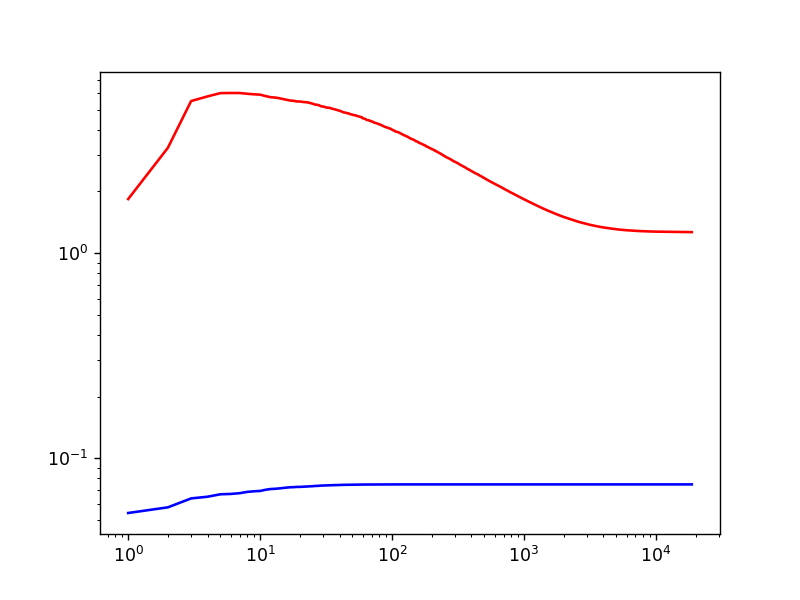

In [146]:
#re-analyze result of minimization procedure
SStates, success = H_Simple_Steady_State(alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], 
                                         d_e=better_result['x'][4], d_i=better_result['x'][5], P=better_result['x'][6], Q=better_result['x'][7])
SStates       

SSnr=0

SStype, found_suitable = GraphWC_Jacobian_TrDet(Laplacian_eigenvalues=eigenvalues2, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                     alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                     sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                     D=better_result['x'][12], tau_e=better_result['x'][13], tau_i=better_result['x'][14])    


Gmatrix = Graph_WC_SpatialPowerSpectrum(Laplacian_eigenvalues=eigenvalues2, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                         D=better_result['x'][12], tau_e=better_result['x'][13], tau_i=better_result['x'][14],
                                        sigma_noise_e=better_result['x'][15], sigma_noise_i=better_result['x'][16],
                                        Visual=True)

In [18]:
#comparison of numerical (nonlinear) simulations and (linearized) semi analytic results 
#(any parameter set; grid laplacian only):
#
#1) test for steady state calculation: simulate (with no noise) on a grid, start directly from SS solution.
#2) test for stability/instability/oscillations: add noise in the grid simulation for specific parameter sets
#3) test for power spectrum calculation: run noisy grid simulation and compare prediction with measured PS (see handwritten notes)
#
################################################################################################
#testing the correctness of the parameter fit procedure(full analysis + minimization algorithm) result
#(intended mainly for the better_result parameter set)
#
#retest minimization algorithm, with objective the current best-fit PS obtained and random initial condition. see if other parameter combinations give the same, ideally converge to same par. set
#
#check (via effect on linearized Jk eigenvalues) if a nearby hopf bifurcation can be induced by changing P or some other parameter 
#(to ask rikkert: do we want this as a prior requirement in minimization? would be hard but doable)
#

In [9]:
#TEST 1-2: STEADY STATES AND STABILITY VIA NUMERICAL SIMULATION
#set up 1D-specific simulation parameters and WCM propagators
one_dim=True
syn=0
gridsize=500
h=0.01
Time=1000
Delta_t=0.001 
one_dim_eigenvalues = one_dim_Laplacian_eigenvalues(gridsize, h, syn)

better_result=dict(x=np.array([ 29.7006292 ,  20.44262474, 150.48968934,  15.1880038 ,
         4.75320173,   4.89206008,   1.19351834,   0.56093785,
         8.93308146,  44.72984834, 168.89277392,  59.76170709,
         9.66636837,   1.30688795,   1.36916604,   3.96300851,
         1.        ]))

#use these if reanalyzing minimization results
aEE=better_result['x'][0]
aIE=better_result['x'][1]
aEI=better_result['x'][2]
aII=better_result['x'][3]
dE=better_result['x'][4]
P=better_result['x'][6]
Q=better_result['x'][7]
dI=better_result['x'][5]
sEE=better_result['x'][8]
sIE=better_result['x'][9]
sEI=better_result['x'][10]
sII=better_result['x'][11]
D=better_result['x'][12]
tE=better_result['x'][13]
tI=better_result['x'][14]
snE=better_result['x'][15]
snI=better_result['x'][16]

#given parameters, calculate steady states
steady_states, success = H_Simple_Steady_State(aEE, aIE, aEI, aII, dE, dI, P, Q)


#for each steady state, compute linear stability and power spectrum
if success==True:
    nrSS=len(steady_states[0])
    allG = np.empty((nrSS,gridsize,2,2), dtype=float)
    SStypes=np.zeros(nrSS)
    for ss in range(nrSS):

        Ess = steady_states[0,ss]
        Iss = steady_states[1,ss]

        SStypes[ss], found_suitable = GraphWC_Jacobian_TrDet(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                         alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
                                         tau_e=tE, tau_i=tI) 


        #allG[ss,:,:,:] = Graph_WC_SpatialPowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
        #                                        alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
        #                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
        #                                         tau_e=tE, tau_i=tI
        #                                         sigma_noise_e=snE, sigma_noise_i=snI, Visual=True)

E*=0.2, I*=0.2044: strictly stable


<IPython.core.display.Javascript object>


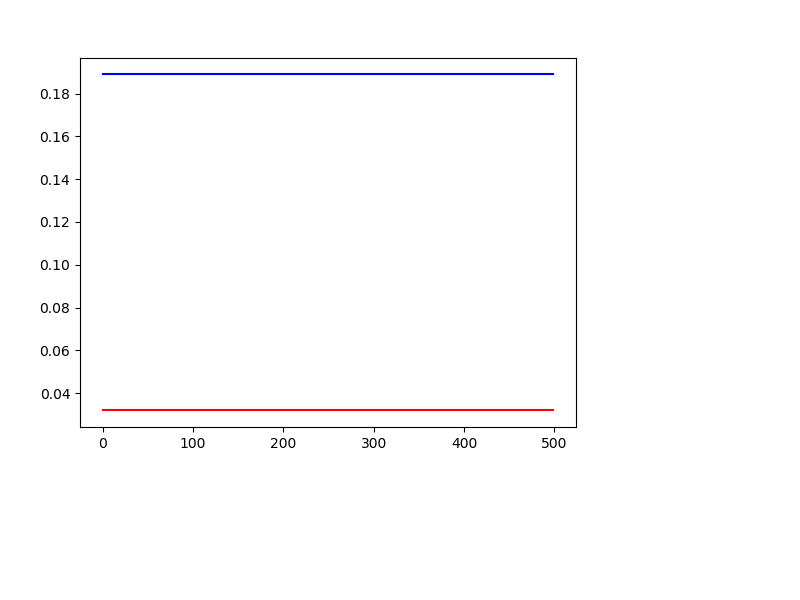

0.03196765313233355 0.1889373764860652
0
(500, 500)
(500,)
1
(500, 500)
(500,)
2
(500, 500)
(500,)
3
(500, 500)
(500,)
4
(500, 500)
(500,)
5
(500, 500)
(500,)
6
(500, 500)
(500,)
7
(500, 500)
(500,)
8
(500, 500)
(500,)
9
(500, 500)
(500,)
10
(500, 500)
(500,)
11
(500, 500)
(500,)
12
(500, 500)
(500,)
13
(500, 500)
(500,)
14
(500, 500)
(500,)
15
(500, 500)
(500,)
16
(500, 500)
(500,)
17
(500, 500)
(500,)
18
(500, 500)
(500,)
19
(500, 500)
(500,)
20
(500, 500)
(500,)
21
(500, 500)
(500,)
22
(500, 500)
(500,)
23
(500, 500)
(500,)
24
(500, 500)
(500,)
25
(500, 500)
(500,)
26
(500, 500)
(500,)
27
(500, 500)
(500,)
28
(500, 500)
(500,)
29
(500, 500)
(500,)
30
(500, 500)
(500,)
31
(500, 500)
(500,)
32
(500, 500)
(500,)
33
(500, 500)
(500,)
34
(500, 500)
(500,)
35
(500, 500)
(500,)
36
(500, 500)
(500,)
37
(500, 500)
(500,)
38
(500, 500)
(500,)
39
(500, 500)
(500,)
40
(500, 500)
(500,)
41
(500, 500)
(500,)
42
(500, 500)
(500,)
43
(500, 500)
(500,)
44
(500, 500)
(500,)
45
(500, 500)
(500,)
46
(5

381
(500, 500)
(500,)
382
(500, 500)
(500,)
383
(500, 500)
(500,)
384
(500, 500)
(500,)
385
(500, 500)
(500,)
386
(500, 500)
(500,)
387
(500, 500)
(500,)
388
(500, 500)
(500,)
389
(500, 500)
(500,)
390
(500, 500)
(500,)
391
(500, 500)
(500,)
392
(500, 500)
(500,)
393
(500, 500)
(500,)
394
(500, 500)
(500,)
395
(500, 500)
(500,)
396
(500, 500)
(500,)
397
(500, 500)
(500,)
398
(500, 500)
(500,)
399
(500, 500)
(500,)
400
(500, 500)
(500,)
401
(500, 500)
(500,)
402
(500, 500)
(500,)
403
(500, 500)
(500,)
404
(500, 500)
(500,)
405
(500, 500)
(500,)
406
(500, 500)
(500,)
407
(500, 500)
(500,)
408
(500, 500)
(500,)
409
(500, 500)
(500,)
410
(500, 500)
(500,)
411
(500, 500)
(500,)
412
(500, 500)
(500,)
413
(500, 500)
(500,)
414
(500, 500)
(500,)
415
(500, 500)
(500,)
416
(500, 500)
(500,)
417
(500, 500)
(500,)
418
(500, 500)
(500,)
419
(500, 500)
(500,)
420
(500, 500)
(500,)
421
(500, 500)
(500,)
422
(500, 500)
(500,)
423
(500, 500)
(500,)
424
(500, 500)
(500,)
425
(500, 500)
(500,)
426
(500, 

781
(500, 500)
(500,)
782
(500, 500)
(500,)
783
(500, 500)
(500,)
784
(500, 500)
(500,)
785
(500, 500)
(500,)
786
(500, 500)
(500,)
787
(500, 500)
(500,)
788
(500, 500)
(500,)
789
(500, 500)
(500,)
790
(500, 500)
(500,)
791
(500, 500)
(500,)
792
(500, 500)
(500,)
793
(500, 500)
(500,)
794
(500, 500)
(500,)
795
(500, 500)
(500,)
796
(500, 500)
(500,)
797
(500, 500)
(500,)
798
(500, 500)
(500,)
799
(500, 500)
(500,)
800
(500, 500)
(500,)
801
(500, 500)
(500,)
802
(500, 500)
(500,)
803
(500, 500)
(500,)
804
(500, 500)
(500,)
805
(500, 500)
(500,)
806
(500, 500)
(500,)
807
(500, 500)
(500,)
808
(500, 500)
(500,)
809
(500, 500)
(500,)
810
(500, 500)
(500,)
811
(500, 500)
(500,)
812
(500, 500)
(500,)
813
(500, 500)
(500,)
814
(500, 500)
(500,)
815
(500, 500)
(500,)
816
(500, 500)
(500,)
817
(500, 500)
(500,)
818
(500, 500)
(500,)
819
(500, 500)
(500,)
820
(500, 500)
(500,)
821
(500, 500)
(500,)
822
(500, 500)
(500,)
823
(500, 500)
(500,)
824
(500, 500)
(500,)
825
(500, 500)
(500,)
826
(500, 

1161
(500, 500)
(500,)
1162
(500, 500)
(500,)
1163
(500, 500)
(500,)
1164
(500, 500)
(500,)
1165
(500, 500)
(500,)
1166
(500, 500)
(500,)
1167
(500, 500)
(500,)
1168
(500, 500)
(500,)
1169
(500, 500)
(500,)
1170
(500, 500)
(500,)
1171
(500, 500)
(500,)
1172
(500, 500)
(500,)
1173
(500, 500)
(500,)
1174
(500, 500)
(500,)
1175
(500, 500)
(500,)
1176
(500, 500)
(500,)
1177
(500, 500)
(500,)
1178
(500, 500)
(500,)
1179
(500, 500)
(500,)
1180
(500, 500)
(500,)
1181
(500, 500)
(500,)
1182
(500, 500)
(500,)
1183
(500, 500)
(500,)
1184
(500, 500)
(500,)
1185
(500, 500)
(500,)
1186
(500, 500)
(500,)
1187
(500, 500)
(500,)
1188
(500, 500)
(500,)
1189
(500, 500)
(500,)
1190
(500, 500)
(500,)
1191
(500, 500)
(500,)
1192
(500, 500)
(500,)
1193
(500, 500)
(500,)
1194
(500, 500)
(500,)
1195
(500, 500)
(500,)
1196
(500, 500)
(500,)
1197
(500, 500)
(500,)
1198
(500, 500)
(500,)
1199
(500, 500)
(500,)
1200
(500, 500)
(500,)
1201
(500, 500)
(500,)
1202
(500, 500)
(500,)
1203
(500, 500)
(500,)
1204
(500, 

1541
(500, 500)
(500,)
1542
(500, 500)
(500,)
1543
(500, 500)
(500,)
1544
(500, 500)
(500,)
1545
(500, 500)
(500,)
1546
(500, 500)
(500,)
1547
(500, 500)
(500,)
1548
(500, 500)
(500,)
1549
(500, 500)
(500,)
1550
(500, 500)
(500,)
1551
(500, 500)
(500,)
1552
(500, 500)
(500,)
1553
(500, 500)
(500,)
1554
(500, 500)
(500,)
1555
(500, 500)
(500,)
1556
(500, 500)
(500,)
1557
(500, 500)
(500,)
1558
(500, 500)
(500,)
1559
(500, 500)
(500,)
1560
(500, 500)
(500,)
1561
(500, 500)
(500,)
1562
(500, 500)
(500,)
1563
(500, 500)
(500,)
1564
(500, 500)
(500,)
1565
(500, 500)
(500,)
1566
(500, 500)
(500,)
1567
(500, 500)
(500,)
1568
(500, 500)
(500,)
1569
(500, 500)
(500,)
1570
(500, 500)
(500,)
1571
(500, 500)
(500,)
1572
(500, 500)
(500,)
1573
(500, 500)
(500,)
1574
(500, 500)
(500,)
1575
(500, 500)
(500,)
1576
(500, 500)
(500,)
1577
(500, 500)
(500,)
1578
(500, 500)
(500,)
1579
(500, 500)
(500,)
1580
(500, 500)
(500,)
1581
(500, 500)
(500,)
1582
(500, 500)
(500,)
1583
(500, 500)
(500,)
1584
(500, 

1901
(500, 500)
(500,)
1902
(500, 500)
(500,)
1903
(500, 500)
(500,)
1904
(500, 500)
(500,)
1905
(500, 500)
(500,)
1906
(500, 500)
(500,)
1907
(500, 500)
(500,)
1908
(500, 500)
(500,)
1909
(500, 500)
(500,)
1910
(500, 500)
(500,)
1911
(500, 500)
(500,)
1912
(500, 500)
(500,)
1913
(500, 500)
(500,)
1914
(500, 500)
(500,)
1915
(500, 500)
(500,)
1916
(500, 500)
(500,)
1917
(500, 500)
(500,)
1918
(500, 500)
(500,)
1919
(500, 500)
(500,)
1920
(500, 500)
(500,)
1921
(500, 500)
(500,)
1922
(500, 500)
(500,)
1923
(500, 500)
(500,)
1924
(500, 500)
(500,)
1925
(500, 500)
(500,)
1926
(500, 500)
(500,)
1927
(500, 500)
(500,)
1928
(500, 500)
(500,)
1929
(500, 500)
(500,)
1930
(500, 500)
(500,)
1931
(500, 500)
(500,)
1932
(500, 500)
(500,)
1933
(500, 500)
(500,)
1934
(500, 500)
(500,)
1935
(500, 500)
(500,)
1936
(500, 500)
(500,)
1937
(500, 500)
(500,)
1938
(500, 500)
(500,)
1939
(500, 500)
(500,)
1940
(500, 500)
(500,)
1941
(500, 500)
(500,)
1942
(500, 500)
(500,)
1943
(500, 500)
(500,)
1944
(500, 

2261
(500, 500)
(500,)
2262
(500, 500)
(500,)
2263
(500, 500)
(500,)
2264
(500, 500)
(500,)
2265
(500, 500)
(500,)
2266
(500, 500)
(500,)
2267
(500, 500)
(500,)
2268
(500, 500)
(500,)
2269
(500, 500)
(500,)
2270
(500, 500)
(500,)
2271
(500, 500)
(500,)
2272
(500, 500)
(500,)
2273
(500, 500)
(500,)
2274
(500, 500)
(500,)
2275
(500, 500)
(500,)
2276
(500, 500)
(500,)
2277
(500, 500)
(500,)
2278
(500, 500)
(500,)
2279
(500, 500)
(500,)
2280
(500, 500)
(500,)
2281
(500, 500)
(500,)
2282
(500, 500)
(500,)
2283
(500, 500)
(500,)
2284
(500, 500)
(500,)
2285
(500, 500)
(500,)
2286
(500, 500)
(500,)
2287
(500, 500)
(500,)
2288
(500, 500)
(500,)
2289
(500, 500)
(500,)
2290
(500, 500)
(500,)
2291
(500, 500)
(500,)
2292
(500, 500)
(500,)
2293
(500, 500)
(500,)
2294
(500, 500)
(500,)
2295
(500, 500)
(500,)
2296
(500, 500)
(500,)
2297
(500, 500)
(500,)
2298
(500, 500)
(500,)
2299
(500, 500)
(500,)
2300
(500, 500)
(500,)
2301
(500, 500)
(500,)
2302
(500, 500)
(500,)
2303
(500, 500)
(500,)
2304
(500, 

2631
(500, 500)
(500,)
2632
(500, 500)
(500,)
2633
(500, 500)
(500,)
2634
(500, 500)
(500,)
2635
(500, 500)
(500,)
2636
(500, 500)
(500,)
2637
(500, 500)
(500,)
2638
(500, 500)
(500,)
2639
(500, 500)
(500,)
2640
(500, 500)
(500,)
2641
(500, 500)
(500,)
2642
(500, 500)
(500,)
2643
(500, 500)
(500,)
2644
(500, 500)
(500,)
2645
(500, 500)
(500,)
2646
(500, 500)
(500,)
2647
(500, 500)
(500,)
2648
(500, 500)
(500,)
2649
(500, 500)
(500,)
2650
(500, 500)
(500,)
2651
(500, 500)
(500,)
2652
(500, 500)
(500,)
2653
(500, 500)
(500,)
2654
(500, 500)
(500,)
2655
(500, 500)
(500,)
2656
(500, 500)
(500,)
2657
(500, 500)
(500,)
2658
(500, 500)
(500,)
2659
(500, 500)
(500,)
2660
(500, 500)
(500,)
2661
(500, 500)
(500,)
2662
(500, 500)
(500,)
2663
(500, 500)
(500,)
2664
(500, 500)
(500,)
2665
(500, 500)
(500,)
2666
(500, 500)
(500,)
2667
(500, 500)
(500,)
2668
(500, 500)
(500,)
2669
(500, 500)
(500,)
2670
(500, 500)
(500,)
2671
(500, 500)
(500,)
2672
(500, 500)
(500,)
2673
(500, 500)
(500,)
2674
(500, 

3001
(500, 500)
(500,)
3002
(500, 500)
(500,)
3003
(500, 500)
(500,)
3004
(500, 500)
(500,)
3005
(500, 500)
(500,)
3006
(500, 500)
(500,)
3007
(500, 500)
(500,)
3008
(500, 500)
(500,)
3009
(500, 500)
(500,)
3010
(500, 500)
(500,)
3011
(500, 500)
(500,)
3012
(500, 500)
(500,)
3013
(500, 500)
(500,)
3014
(500, 500)
(500,)
3015
(500, 500)
(500,)
3016
(500, 500)
(500,)
3017
(500, 500)
(500,)
3018
(500, 500)
(500,)
3019
(500, 500)
(500,)
3020
(500, 500)
(500,)
3021
(500, 500)
(500,)
3022
(500, 500)
(500,)
3023
(500, 500)
(500,)
3024
(500, 500)
(500,)
3025
(500, 500)
(500,)
3026
(500, 500)
(500,)
3027
(500, 500)
(500,)
3028
(500, 500)
(500,)
3029
(500, 500)
(500,)
3030
(500, 500)
(500,)
3031
(500, 500)
(500,)
3032
(500, 500)
(500,)
3033
(500, 500)
(500,)
3034
(500, 500)
(500,)
3035
(500, 500)
(500,)
3036
(500, 500)
(500,)
3037
(500, 500)
(500,)
3038
(500, 500)
(500,)
3039
(500, 500)
(500,)
3040
(500, 500)
(500,)
3041
(500, 500)
(500,)
3042
(500, 500)
(500,)
3043
(500, 500)
(500,)
3044
(500, 

3361
(500, 500)
(500,)
3362
(500, 500)
(500,)
3363
(500, 500)
(500,)
3364
(500, 500)
(500,)
3365
(500, 500)
(500,)
3366
(500, 500)
(500,)
3367
(500, 500)
(500,)
3368
(500, 500)
(500,)
3369
(500, 500)
(500,)
3370
(500, 500)
(500,)
3371
(500, 500)
(500,)
3372
(500, 500)
(500,)
3373
(500, 500)
(500,)
3374
(500, 500)
(500,)
3375
(500, 500)
(500,)
3376
(500, 500)
(500,)
3377
(500, 500)
(500,)
3378
(500, 500)
(500,)
3379
(500, 500)
(500,)
3380
(500, 500)
(500,)
3381
(500, 500)
(500,)
3382
(500, 500)
(500,)
3383
(500, 500)
(500,)
3384
(500, 500)
(500,)
3385
(500, 500)
(500,)
3386
(500, 500)
(500,)
3387
(500, 500)
(500,)
3388
(500, 500)
(500,)
3389
(500, 500)
(500,)
3390
(500, 500)
(500,)
3391
(500, 500)
(500,)
3392
(500, 500)
(500,)
3393
(500, 500)
(500,)
3394
(500, 500)
(500,)
3395
(500, 500)
(500,)
3396
(500, 500)
(500,)
3397
(500, 500)
(500,)
3398
(500, 500)
(500,)
3399
(500, 500)
(500,)
3400
(500, 500)
(500,)
3401
(500, 500)
(500,)
3402
(500, 500)
(500,)
3403
(500, 500)
(500,)
3404
(500, 

3721
(500, 500)
(500,)
3722
(500, 500)
(500,)
3723
(500, 500)
(500,)
3724
(500, 500)
(500,)
3725
(500, 500)
(500,)
3726
(500, 500)
(500,)
3727
(500, 500)
(500,)
3728
(500, 500)
(500,)
3729
(500, 500)
(500,)
3730
(500, 500)
(500,)
3731
(500, 500)
(500,)
3732
(500, 500)
(500,)
3733
(500, 500)
(500,)
3734
(500, 500)
(500,)
3735
(500, 500)
(500,)
3736
(500, 500)
(500,)
3737
(500, 500)
(500,)
3738
(500, 500)
(500,)
3739
(500, 500)
(500,)
3740
(500, 500)
(500,)
3741
(500, 500)
(500,)
3742
(500, 500)
(500,)
3743
(500, 500)
(500,)
3744
(500, 500)
(500,)
3745
(500, 500)
(500,)
3746
(500, 500)
(500,)
3747
(500, 500)
(500,)
3748
(500, 500)
(500,)
3749
(500, 500)
(500,)
3750
(500, 500)
(500,)
3751
(500, 500)
(500,)
3752
(500, 500)
(500,)
3753
(500, 500)
(500,)
3754
(500, 500)
(500,)
3755
(500, 500)
(500,)
3756
(500, 500)
(500,)
3757
(500, 500)
(500,)
3758
(500, 500)
(500,)
3759
(500, 500)
(500,)
3760
(500, 500)
(500,)
3761
(500, 500)
(500,)
3762
(500, 500)
(500,)
3763
(500, 500)
(500,)
3764
(500, 

4101
(500, 500)
(500,)
4102
(500, 500)
(500,)
4103
(500, 500)
(500,)
4104
(500, 500)
(500,)
4105
(500, 500)
(500,)
4106
(500, 500)
(500,)
4107
(500, 500)
(500,)
4108
(500, 500)
(500,)
4109
(500, 500)
(500,)
4110
(500, 500)
(500,)
4111
(500, 500)
(500,)
4112
(500, 500)
(500,)
4113
(500, 500)
(500,)
4114
(500, 500)
(500,)
4115
(500, 500)
(500,)
4116
(500, 500)
(500,)
4117
(500, 500)
(500,)
4118
(500, 500)
(500,)
4119
(500, 500)
(500,)
4120
(500, 500)
(500,)
4121
(500, 500)
(500,)
4122
(500, 500)
(500,)
4123
(500, 500)
(500,)
4124
(500, 500)
(500,)
4125
(500, 500)
(500,)
4126
(500, 500)
(500,)
4127
(500, 500)
(500,)
4128
(500, 500)
(500,)
4129
(500, 500)
(500,)
4130
(500, 500)
(500,)
4131
(500, 500)
(500,)
4132
(500, 500)
(500,)
4133
(500, 500)
(500,)
4134
(500, 500)
(500,)
4135
(500, 500)
(500,)
4136
(500, 500)
(500,)
4137
(500, 500)
(500,)
4138
(500, 500)
(500,)
4139
(500, 500)
(500,)
4140
(500, 500)
(500,)
4141
(500, 500)
(500,)
4142
(500, 500)
(500,)
4143
(500, 500)
(500,)
4144
(500, 

In [ ]:
#Now, run a deterministic, 1D grid simulation to verify that steady states are correct
nrSS=0          
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    
E_0 = np.ones(gridsize)*Ess
I_0 = np.ones(gridsize)*Iss

propagatorEE, propagatorIE, propagatorEI, propagatorII = graph_WCM_propagators(Graph_Kernel='Gaussian',
                       alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII,
                       sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D,
                       one_dim=one_dim, syn=syn, gridsize=gridsize, h=h)

Graph_Wilson_Cowan_Model(E_0, I_0, Time, Delta_t,
                          propagatorEE, propagatorIE, propagatorEI, propagatorII, 
                          dE, dI, P, Q, tE, tI, sigma_noise_e=0, sigma_noise_i=0, Visual=True)   

3 unique steady states were found
